# Import

In [1]:
import os, sys

import pandas as pd
import polars as pl

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy

import sklearn
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import dproc, sgml, sgnn, sgpp, sgutil

print(sys.version)
for i in [pd, pl, mpl, sns, np, scipy, sklearn, lgb, xgb, cb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

2025-02-04 05:27:37.000020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738646857.011422   41584 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738646857.014942   41584 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 05:27:37.027129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
pandas 2.2.3
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
scipy 1.12.0
sklearn 1.5.2
xgboost 2.1.2
catboost 1.2.5


In [2]:
from itertools import combinations

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from scipy.stats import spearmanr, kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

# Download

In [3]:
for i in ['data', 'model', 'img', 'result']:
    if not os.path.exists(i):
        os.mkdir(i)

if not os.path.exists(os.path.join('data', 'train.csv')):
    !kaggle competitions download -c playground-series-s5e2
    !kaggle datasets download souradippal/student-bag-price-prediction-dataset
    !unzip student-bag-price-prediction-dataset.zip -d data
    !unzip playground-series-s5e2.zip -d data
    !rm playground-series-s5e2.zip
    !rm student-bag-price-prediction-dataset.zip

# Preparation

In [4]:
sc = sgutil.SGCache('img', 'result')
ss = ShuffleSplit(n_splits = 1, random_state = 123)
kf = KFold(5, random_state = 123, shuffle=True)

In [5]:
files = {
    'train': os.path.join('data', 'train.csv'),
    'test': os.path.join('data', 'test.csv'),
    'org': os.path.join('data', 'Noisy_Student_Bag_Price_Prediction_Dataset.csv')
}

In [6]:
t = sc.cache_result(
    'pipeline_1',
    lambda : make_pipeline(
        sgpp.PolarsProcessor(), 
        sgpp.PandasCoverter(index_col = 'id'),
    ).fit(files['train']),
    rerun = 0
)
df_train = t.transform(files['train'])
df_test = t.transform(files['test'])
df_org = t.transform(files['org'])
df_org.set_index(-(df_org.index.rename('id') + 1), inplace=True)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Brand                 290295 non-null  category
 1   Material              291653 non-null  category
 2   Size                  293405 non-null  category
 3   Compartments          300000 non-null  float32 
 4   Laptop Compartment    292556 non-null  category
 5   Waterproof            292950 non-null  category
 6   Style                 292030 non-null  category
 7   Color                 290050 non-null  category
 8   Weight Capacity (kg)  299862 non-null  float32 
 9   Price                 300000 non-null  float32 
dtypes: category(7), float32(3)
memory usage: 6.6 MB


In [8]:
target = 'Price'
X_cat = df_train.dtypes.pipe(
    lambda x: x.loc[x == 'category'].index.tolist()
)
X_num = df_train.dtypes.pipe(
    lambda x: x.loc[(x != 'category') & (x.index != target)].index.tolist()
)
X_all = X_cat + X_num
target, X_cat, X_num

('Price',
 ['Brand',
  'Material',
  'Size',
  'Laptop Compartment',
  'Waterproof',
  'Style',
  'Color'],
 ['Compartments', 'Weight Capacity (kg)'])

In [9]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index).clip(15, 150),
    'score_func': lambda df, prds: root_mean_squared_error(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)
lr_adapter = sgml.SklearnAdapter(LinearRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor)

# EDA

## Train / Test / Org Diff

In [10]:
X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)']
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'train_test_diff',
    lambda : pd.concat([df_train[X_all_diff].assign(is_train = True), df_test[X_all_diff].assign(is_train = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_train'], cv = ss, scoring = 'roc_auc')
    )
)

array([0.50166391])

In [11]:
X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)', target]
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'train_org_diff',
    lambda : pd.concat([df_train[X_all_diff].assign(is_train = True), df_org[X_all_diff].assign(is_train = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_train'], cv = ss, scoring = 'roc_auc')
    )
)

array([0.61373943])

In [12]:
X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)']
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'org_test_diff',
    lambda : pd.concat([df_org[X_all_diff].assign(is_org = True), df_test[X_all_diff].assign(is_org = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_org'], cv = ss, scoring = 'roc_auc')
    )
)

array([0.60868605])

Although there appears to be some difference from the original data, the separation is not clear. It is worth investigating whether incorporating the original data might contribute to performance improvements.

## Missing Values

In [13]:
df_train[X_all].isna().mean().pipe(
    lambda x: x.loc[x > 0].rename('na_ratio').to_frame().T
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
na_ratio,0.03235,0.027823,0.021983,0.024813,0.0235,0.026567,0.033167,0.00046


In [14]:
df_train[X_all].isna().sum(axis=1).value_counts(normalize=True)

0    0.822287
1    0.165853
2    0.010877
3    0.000877
4    0.000107
Name: proportion, dtype: float64

## Target

In [15]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Price,300000.0,81.41111,39.039341,15.0,47.384621,80.956123,115.018158,150.0


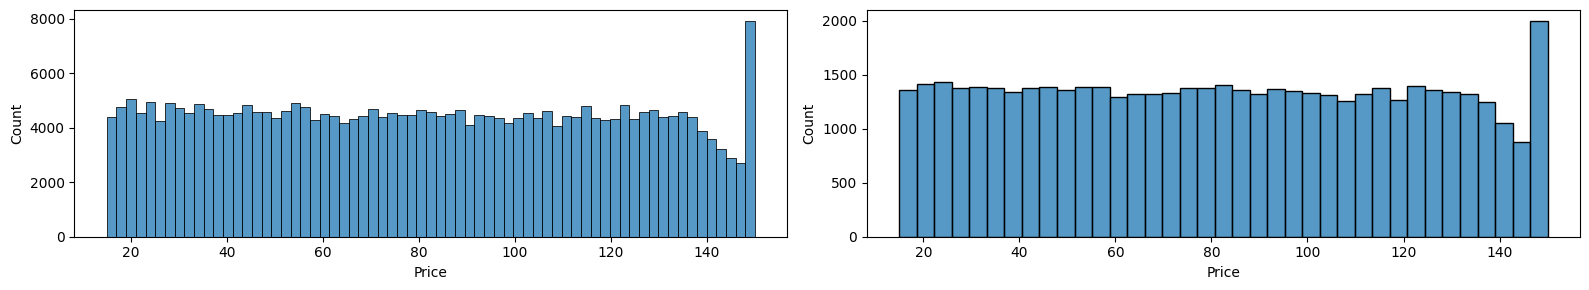

In [16]:
_, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train[target], ax = axes[0])
sns.histplot(df_org[target], ax = axes[1])
plt.tight_layout()
plt.show()

In [17]:
df_train[target].value_counts(normalize=True).iloc[:5]

Price
150.000000    0.018427
15.000000     0.002310
23.595840     0.000073
37.411259     0.000070
17.315140     0.000070
Name: proportion, dtype: float64

It is highly likely that the target has been clipped to values between 15 and 150.

## Categorical Variables

In [18]:
# Using Kruskal analysis, we examine the relationship between the categorical variables and the target.
sc.cache_result(
    'kruskal_target',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index=['stat', 'pvalue'], name=i
        ) for i in X_cat
    ], axis=1), rerun = 0
).T.join(df_train[X_cat].nunique().rename('nunique')).sort_values('pvalue', ascending = True)

,stat,pvalue,nunique
Material,94.397776,2.487334e-20,4
Color,81.778818,3.560963e-16,6
Brand,42.562866,1.275070e-08,5
Waterproof,1.589209,2.074391e-01,2
Size,2.902191,2.343134e-01,3
Laptop Compartment,0.009281,9.232525e-01,2
Style,0.068897,9.661381e-01,3


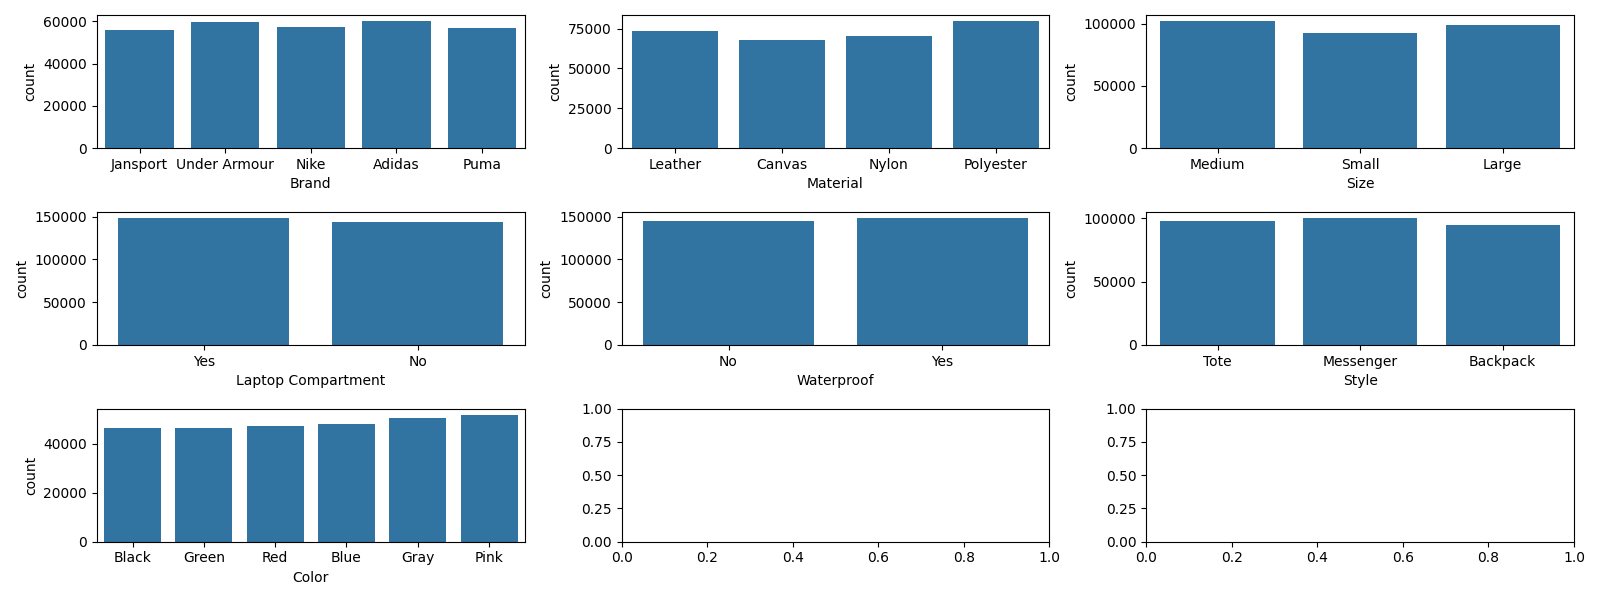

In [19]:
sc.cache_fig(
    'count_plot',
    lambda x: [sns.countplot(df_train, x = a, ax=b) for a, b in zip(X_cat, x)],
    3, 3, (16, 6), redraw = 0
)

In [20]:
# Using the chi-square independence test, we examine the relationships among the categorical variables.
pd.DataFrame(
    squareform(
        sc.cache_result(
            'chi2_variables',
            lambda : pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(u, v)).pvalue)
        )
    ), index = X_cat, columns = X_cat
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
Brand,0.000000e+00,1.326258e-07,0.093020,1.240839e-01,1.814956e-01,0.029342,0.479126
Material,1.326258e-07,0.000000e+00,0.000014,8.355747e-02,9.095699e-01,0.140027,0.038341
Size,9.302043e-02,1.374196e-05,0.000000,7.578808e-01,9.230872e-01,0.032041,0.012190
Laptop Compartment,1.240839e-01,8.355747e-02,0.757881,0.000000e+00,3.246753e-56,0.004470,0.007520
Waterproof,1.814956e-01,9.095699e-01,0.923087,3.246753e-56,0.000000e+00,0.789501,0.483258
Style,2.934222e-02,1.400270e-01,0.032041,4.469708e-03,7.895010e-01,0.000000,0.147923
Color,4.791256e-01,3.834111e-02,0.012190,7.520067e-03,4.832583e-01,0.147923,0.000000


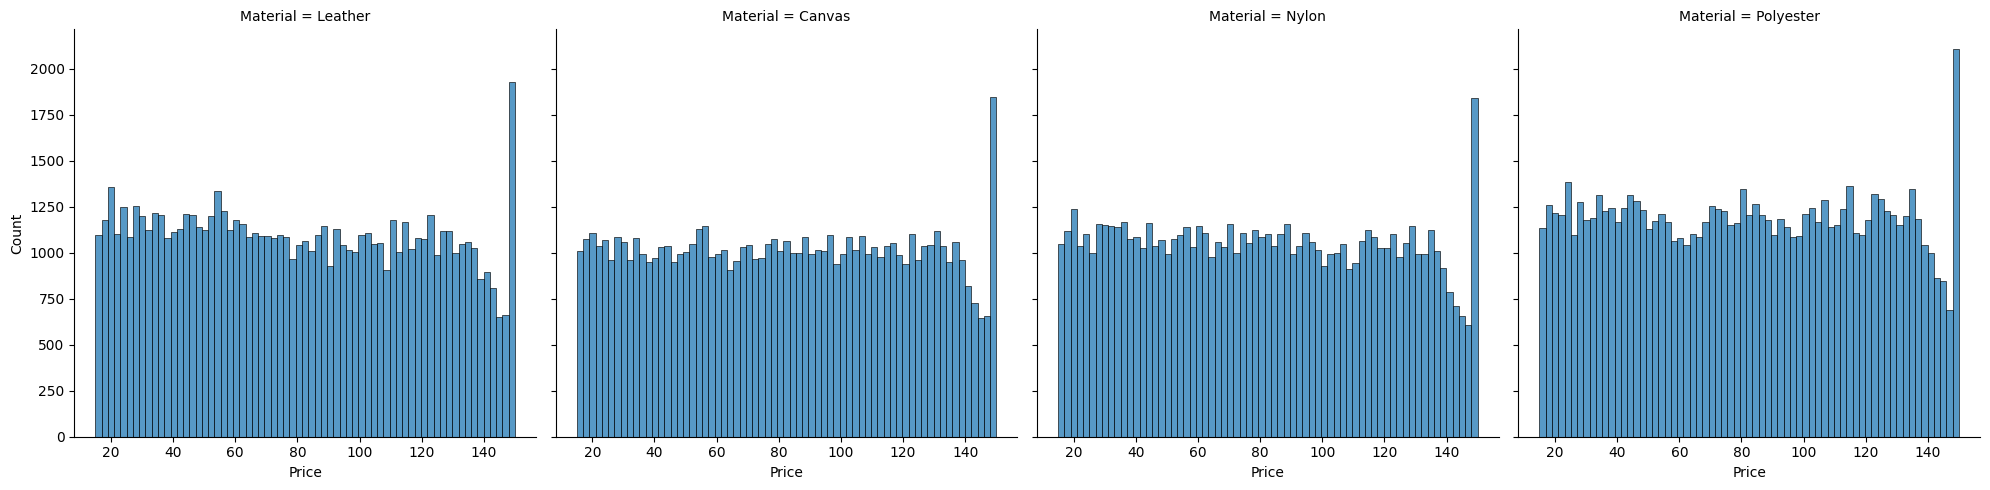

In [21]:
# According to the results of the Kruskal analysis, the Material attribute has the strongest association with the target. A histogram of the target is then plotted based on Material.
sns.displot(df_train, x = target , col = 'Material')
plt.show()

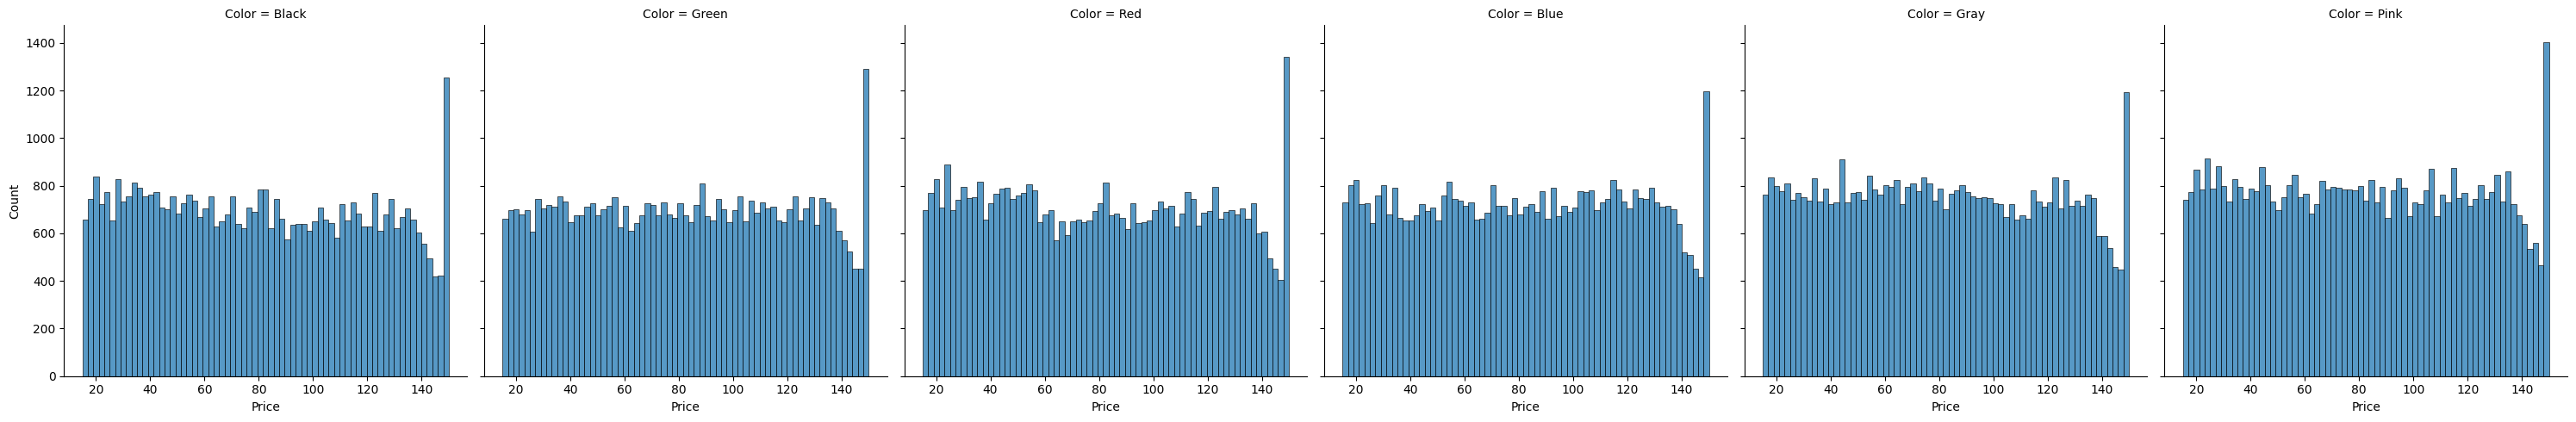

In [22]:
# The next strongest association with the target is Color.
sns.displot(df_train, x = target , col = 'Color')
plt.show()

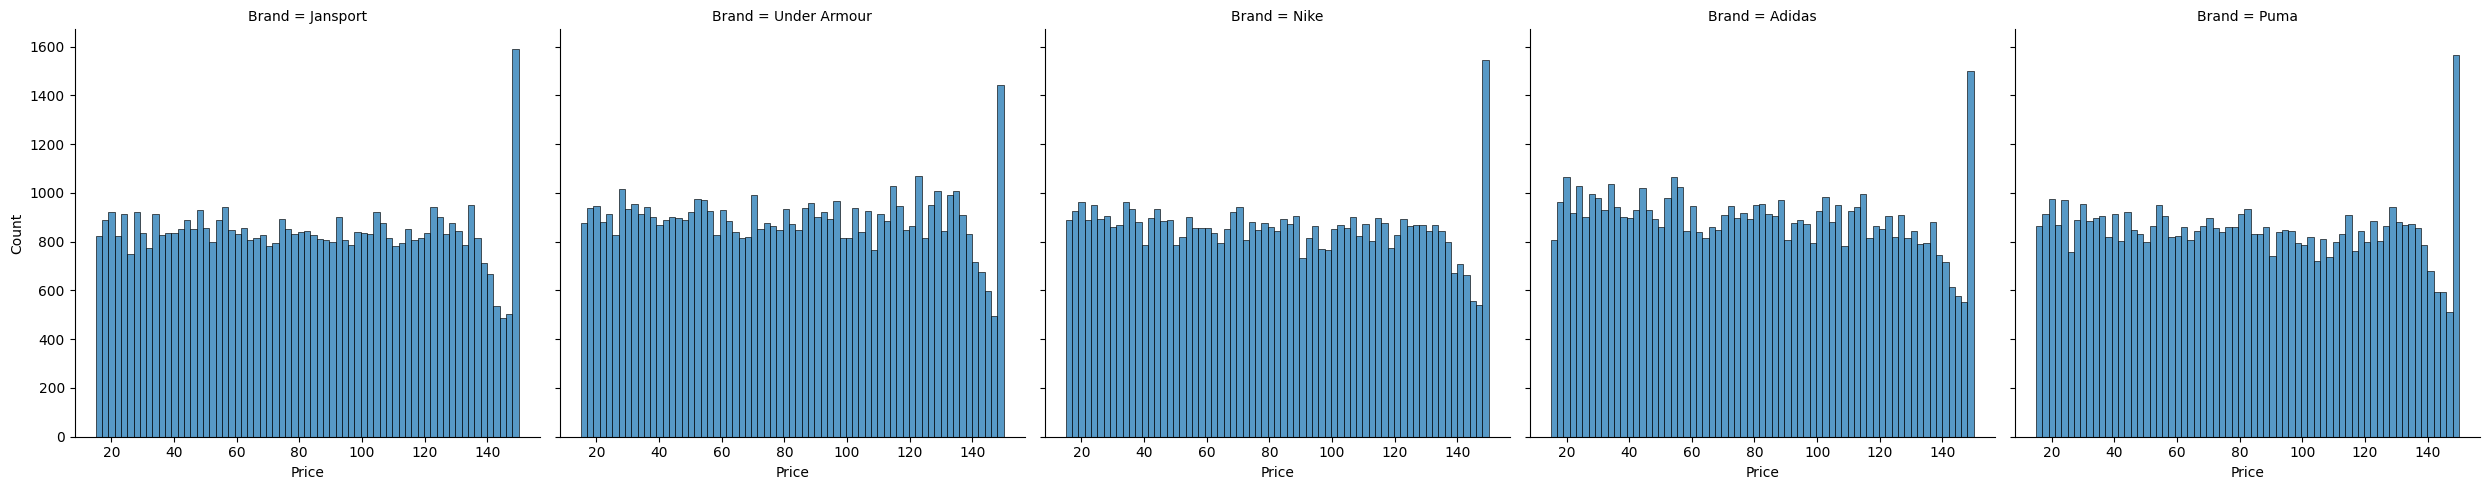

In [23]:
# The next strongest association with the target is Brand.
sns.displot(df_train, x = target , col = 'Brand')
plt.show()

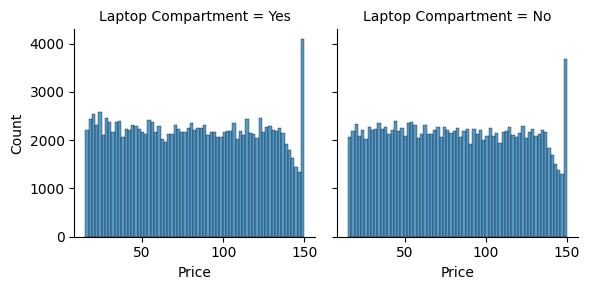

In [24]:
# The next strongest association with the target is Laptop Compartment.
sns.displot(df_train, x = target , col = 'Laptop Compartment', height = 3)
plt.show()

In [25]:
df_train.groupby('Material', observed = True)[target].median().to_frame().T

Material,Leather,Canvas,Nylon,Polyester
Price,79.166779,82.148575,80.271378,81.971069


It is difficult to discern clear differences in the target through visualization.

<Axes: xlabel='count', ylabel='Count'>

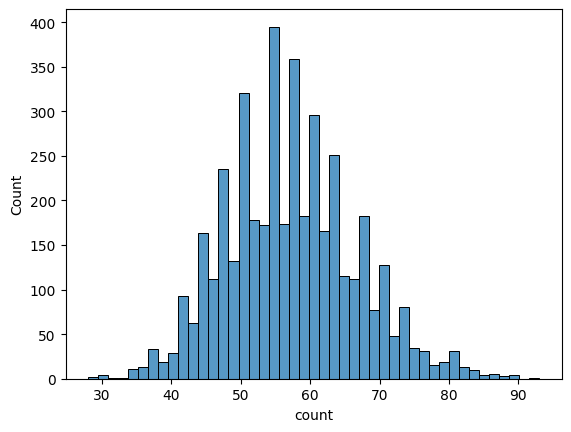

In [60]:
sns.histplot(df_train[X_cat].dropna().value_counts())

In [57]:
def rmse_tgt_enc_cat(X, cv = ShuffleSplit(n_splits=1, random_state = 123)):
    tgt = TargetEncoder(random_state = 123, target_type  = 'continuous')
    rmse_list = list()
    for train_idx, valid_idx in cv.split(df_train[X], df_train[target]):
        df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
        df_cv_train, df_valid = df_cv_train.dropna(), df_valid.dropna()
        if len(X) == 0:
            rmse_list.append(df_valid[target].std())
            continue
        if len(X) > 1:
            tgt.fit(dproc.combine_cat(df_cv_train[X]).to_frame(), df_cv_train[target])
            rmse_list.append(
                root_mean_squared_error(df_valid[target], tgt.transform(dproc.combine_cat(df_valid[X]).to_frame()))
            )
        else:
            tgt.fit(df_cv_train[X], df_cv_train[target])
            rmse_list.append(
                root_mean_squared_error(df_valid[target], tgt.transform(df_valid[X]))
            )
    return np.mean(rmse_list)

def get_comb_cat_rmse_tgt(n, cv = ShuffleSplit(n_splits=1, random_state = 123), X_cat = X_cat):
    return pd.Index(combinations(X_cat, n)).to_series().map(
        lambda x: rmse_tgt_enc_cat(list(x), cv)
    ).sort_values()

In [28]:
rmse_base = rmse_tgt_enc_cat([], kf)
rmse_base

38.940063

In [29]:
rmse_comb_cat_list = sc.cache_result(
    'comb_cat_rmse',
    lambda : [get_comb_cat_rmse_tgt(i, kf) for i in range(1, len(X_cat) + 1)], rerun = 0
)
for i in rmse_comb_cat_list:
    display(i.iloc[:5])

Material              38.934925
Color                 38.934949
Brand                 38.937442
Size                  38.940097
Laptop Compartment    38.940186
dtype: float64

Material            Color         38.931884
Brand               Material      38.933552
                    Color         38.934159
Laptop Compartment  Color         38.935214
Material            Waterproof    38.935242
dtype: float64

Material  Waterproof          Color                 38.934496
          Laptop Compartment  Color                 38.934530
          Size                Color                 38.934694
Brand     Material            Waterproof            38.934730
                              Laptop Compartment    38.935133
dtype: float64

Material  Laptop Compartment  Waterproof          Color         38.937816
Brand     Material            Laptop Compartment  Waterproof    38.938518
Material  Laptop Compartment  Waterproof          Style         38.938879
          Size                Laptop Compartment  Waterproof    38.940079
                              Waterproof          Style         38.940772
dtype: float64

Material  Size                Laptop Compartment  Waterproof          Style         38.949328
Brand     Size                Laptop Compartment  Waterproof          Style         38.952619
          Material            Laptop Compartment  Waterproof          Style         38.954429
Size      Laptop Compartment  Waterproof          Style               Color         38.955149
Brand     Material            Size                Laptop Compartment  Waterproof    38.955180
dtype: float64

Brand     Material  Size                Laptop Compartment  Waterproof  Style    39.001839
Material  Size      Laptop Compartment  Waterproof          Style       Color    39.014767
Brand     Size      Laptop Compartment  Waterproof          Style       Color    39.034922
          Material  Size                Laptop Compartment  Waterproof  Color    39.063883
                    Laptop Compartment  Waterproof          Style       Color    39.073126
dtype: float64

Brand  Material  Size  Laptop Compartment  Waterproof  Style  Color    39.338896
dtype: float64

## Numerical Variables

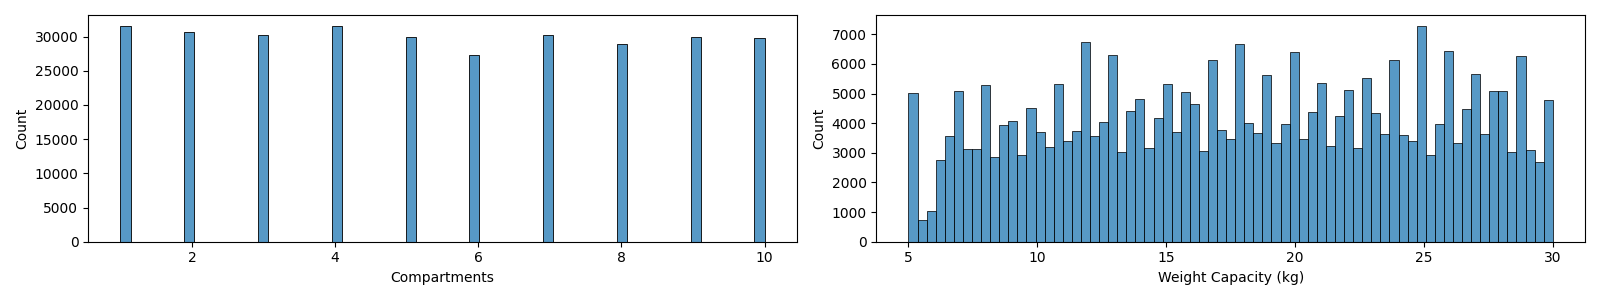

In [30]:
sc.cache_fig(
    'hist_plot',
    lambda x: [sns.histplot(df_train, x = a, ax=b) for a, b in zip(X_num, x)],
    1, 2, (16, 3), redraw = 0
)

<Axes: xlabel='Weight Capacity (kg)', ylabel='Price'>

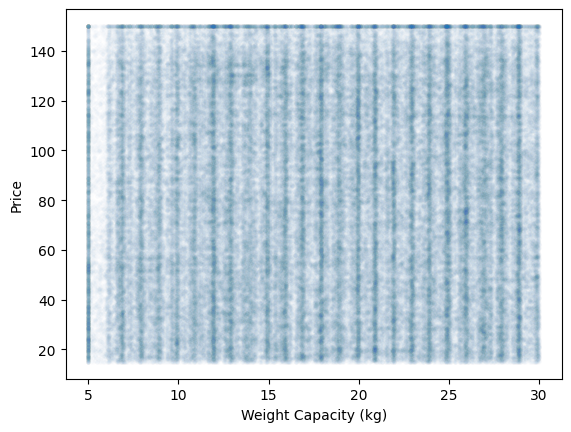

In [64]:
sns.scatterplot(
    df_train, x = 'Weight Capacity (kg)', y = target, alpha = 0.01, s = 10
)


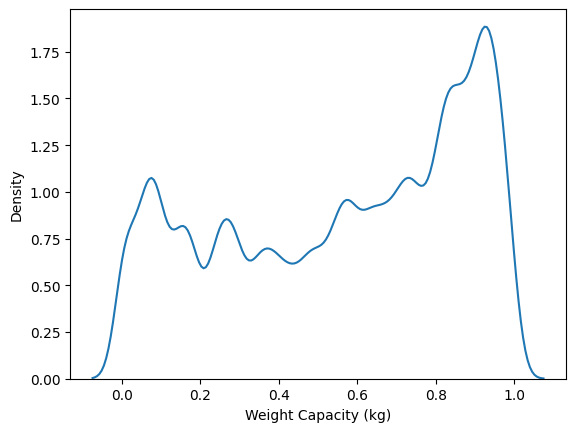

In [73]:
# hist. of floating part of Weight Capacity (kg)
sns.kdeplot(df_train['Weight Capacity (kg)'].dropna().pipe(lambda x: x - x.astype('int')))
plt.show()

Weight Capacity tends to be concentrated at points where the first decimal place is 0. It may be worth rounding to the nearest integer at the first decimal place.

In [31]:
# Spearman correlation between Target and the numerical variables.
df_train[X_num].apply(
    lambda x: pd.Series(spearmanr(x.loc[x.notna()], df_train.loc[x.notna(), target]), index = ['r', 'pvalue']), axis = 0
)    

,Compartments,Weight Capacity (kg)
r,-0.000241,1.749693e-02
pvalue,0.894956,9.522767e-22


In [32]:
# Spearman correlation of each pairs of the numerical variables.
df_train[X_num].corr()

,Compartments,Weight Capacity (kg)
Compartments,1.000000,0.002542
Weight Capacity (kg),0.002542,1.000000


In [33]:
# Kruskal of each pairs of the categorical variables and the numerical variables.
sc.cache_result(
    'kruskal_cat_num',
    lambda : df_train.dropna().pipe(
        lambda x: pd.concat([
            x.groupby(i, observed=True)[X_num].agg(list).apply(
                lambda x: pd.Series(kruskal(*x), index=['stat', 'pvalue']), axis = 0
            ).loc['pvalue'].rename(i)
            for i in X_cat
        ], axis=1)
    )
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
Compartments,0.298016,9.503854e-05,0.000725,0.502259,0.033463,0.001422,0.39020
Weight Capacity (kg),0.000705,4.674100e-08,0.432098,0.260145,0.163490,0.195311,0.52509


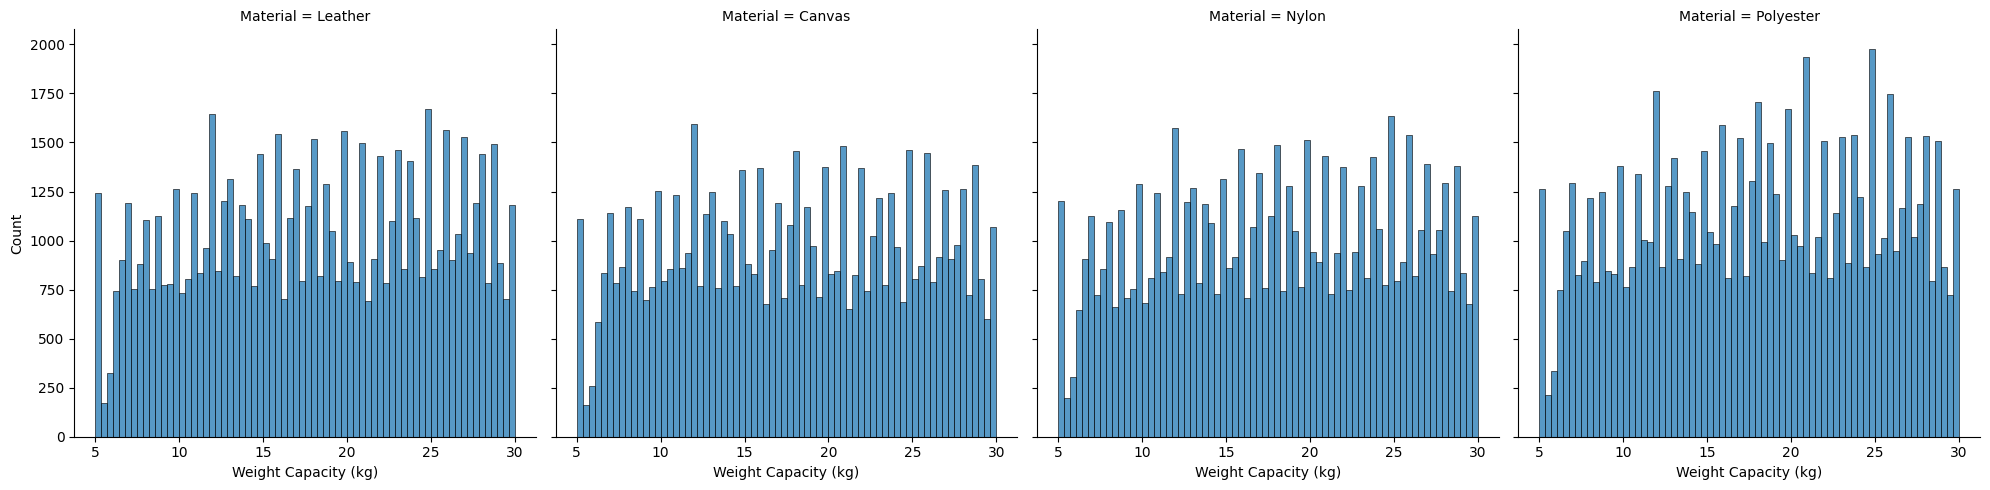

In [34]:
sns.displot(df_train, x = 'Weight Capacity (kg)', col = 'Material')
plt.show()

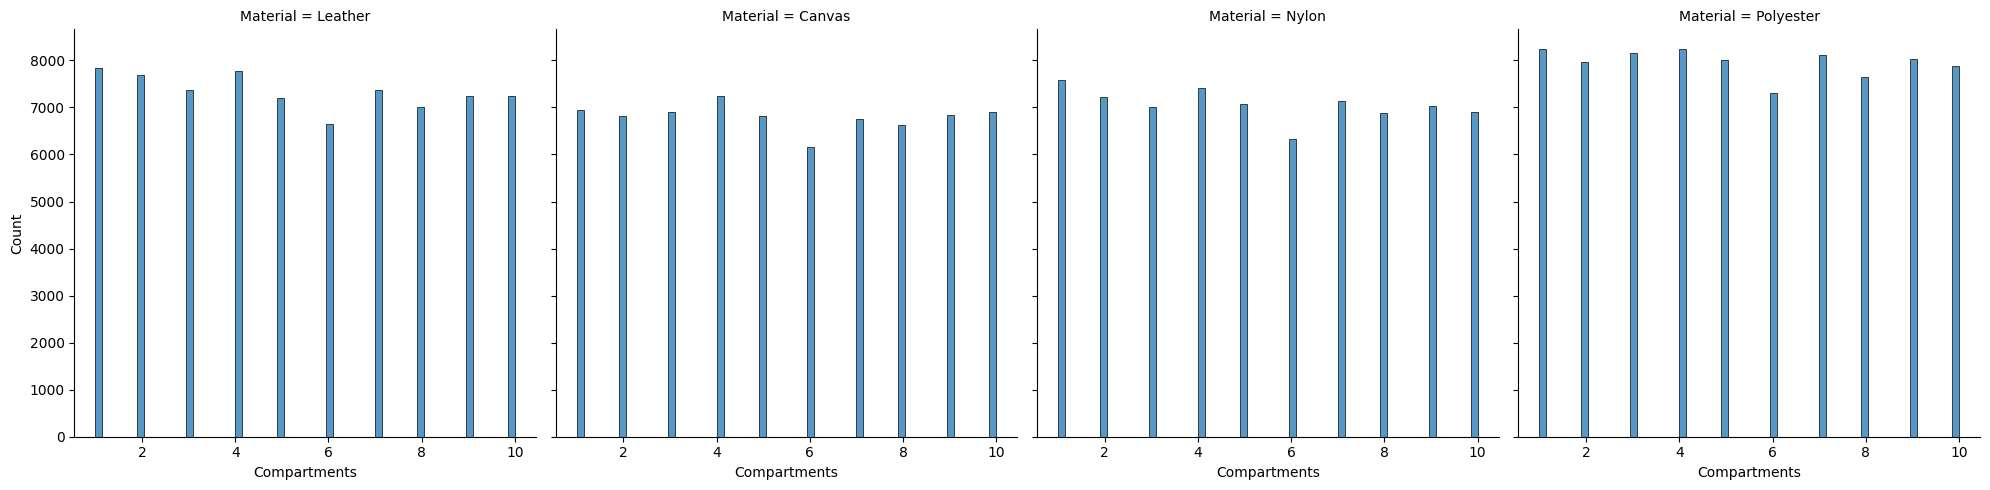

In [35]:
sns.displot(df_train, x = 'Compartments', col = 'Material')
plt.show()

In [36]:
df_train.groupby('Material', observed=True)[X_num].median()

,Compartments,Weight Capacity (kg)
Material,,
Leather,5.0,18.092140
Canvas,5.0,17.918560
Nylon,5.0,18.064470
Polyester,5.0,18.207628


In [37]:
df_train.groupby('Material', observed=True)['Compartments'].mean().to_frame().T

Material,Leather,Canvas,Nylon,Polyester
Compartments,5.417716,5.47356,5.431979,5.459274


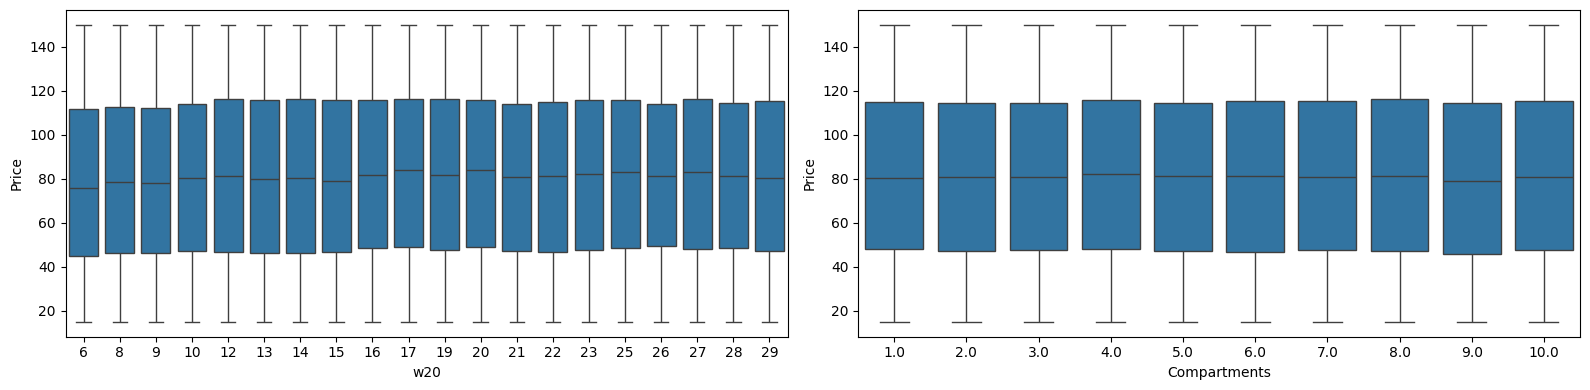

In [38]:
_, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(
    df_train.assign(
        w20 = pd.qcut(df_train['Weight Capacity (kg)'], q=20).pipe(lambda x: x.apply(lambda x: round((x.left + x.right) / 2))), observed=True
    ), x = 'w20', y = target, ax = axes[0]
)

sns.boxplot(
    df_train, x = 'Compartments', y = target,
    ax = axes[1]
)
plt.tight_layout()
plt.show()

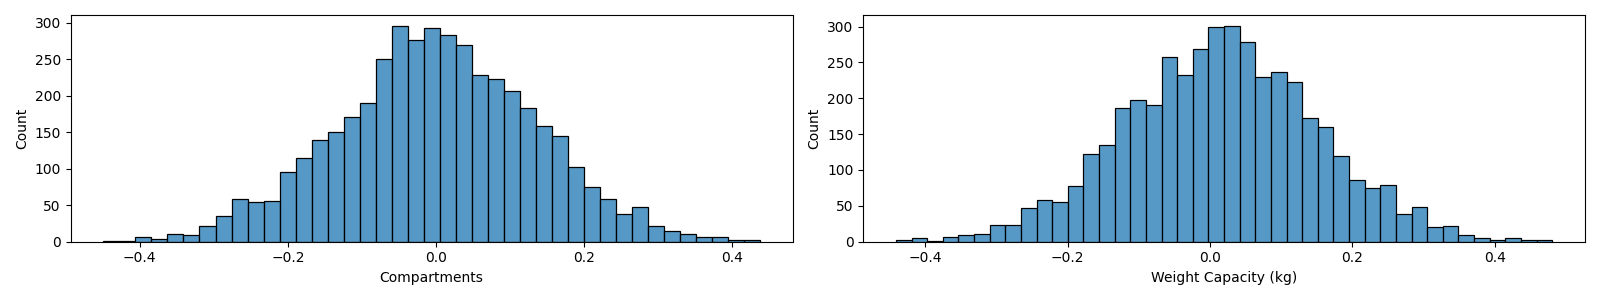

In [39]:
# We examine the distribution of the Spearman correlations between the Target and continuous variables, separated by categorical variables.
sc.cache_fig(
    'spearmanr_groupby_cat',
    lambda x: 
        [sns.histplot(df_train.dropna().groupby(X_cat, observed = True)[X_num + [target]].apply(
            lambda x: spearmanr(x[a], x[target]).statistic
        ).rename(a).to_frame(), x = a, ax=b) for a,b in zip(X_num, x)]
    , 1, 2, figsize = (16, 3), redraw = 0
)

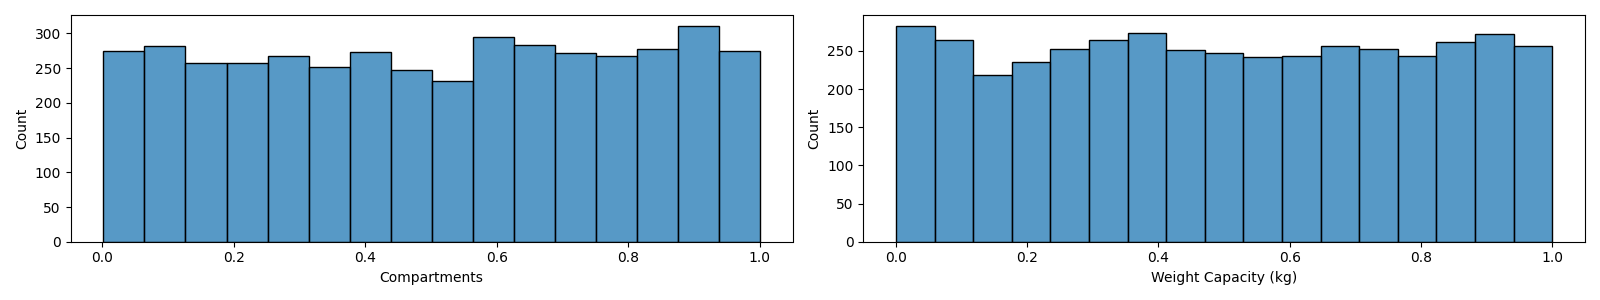

In [40]:
# We examine the distribution of the pvalues of Spearman correlations analysis between the Target and continuous variables, separated by categorical variables.
sc.cache_fig(
    'spearmanr_groupby_cat_pvalue',
    lambda x: 
        [sns.histplot(df_train.dropna().groupby(X_cat, observed = True)[X_num + [target]].apply(
            lambda x: spearmanr(x[a], x[target]).pvalue
        ).rename(a).to_frame(), x = a, ax=b) for a,b in zip(X_num, x)]
    , 1, 2, figsize = (16, 3), redraw = 0
)

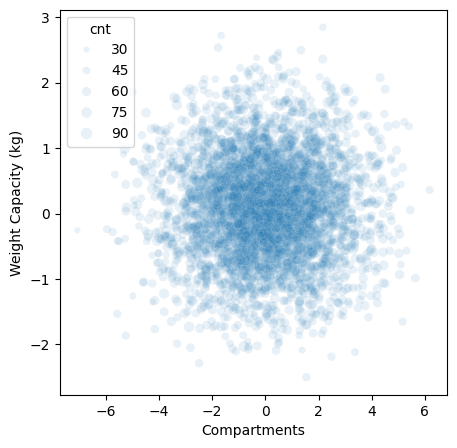

In [41]:
_ = plt.figure(figsize = (5, 5))
df_lr_result = sc.cache_result(
    'lr_result_groupby_cat',
    lambda : df_train.groupby(X_cat, observed = True)[X_num + [target]].apply(
        lambda x: LinearRegression().fit(x[X_num], x[target])
    ).pipe(
        lambda x: x.apply(lambda x: pd.Series(x.coef_, index = X_num)).join(x.apply(lambda x: x.intercept_).rename('intecept'))
    )
).join(df_train[X_cat].value_counts().rename('cnt'))
sns.scatterplot(df_lr_result, x = X_num[0], y = X_num[1], alpha = 0.1, size = 'cnt')
plt.show()

<Axes: ylabel='Count'>

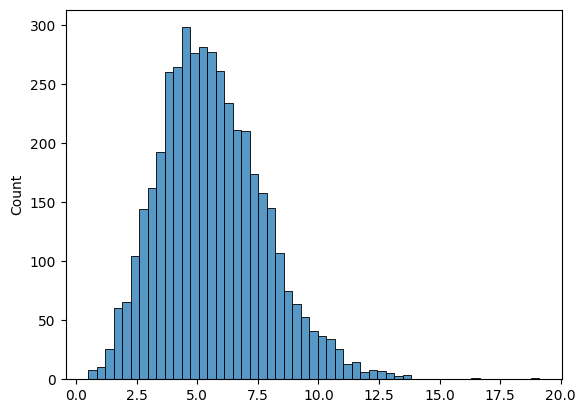

In [42]:
df_cv_lr_result = sc.cache_result(
    'cv_lr_rmse_groupby_cat',
    lambda : df_train.groupby(X_cat, observed = True)[X_num + [target]].apply(
        lambda x: cross_val_score(LinearRegression(), x[X_num], x[target], cv = kf, scoring = 'neg_root_mean_squared_error')
    )
).apply(lambda x: pd.Series(x))
sns.histplot(df_cv_lr_result.std(axis=1))

In [43]:
df_cv_vs_std = pd.concat([
    (-df_cv_lr_result.mean(axis=1)).rename('rmse_lr'),
    df_train.groupby(X_cat, observed=True)[target].apply(
        lambda x: x.sample(frac = 0.8).pipe(lambda y: ((x.loc[~x.index.isin(y.index)] - y.mean()) ** 2).mean() ** 0.5)
    ).rename('std')
], axis=1).join(
    df_train[X_cat].value_counts(normalize = True).rename('w')
)
(df_cv_vs_std['rmse_lr'] - df_cv_vs_std['std']).dot(
    df_cv_vs_std['w']
)

0.9116719861013404

In [44]:
df_cv_vs_std['rmse_lr'].dot(df_cv_vs_std['w']), df_cv_vs_std['std'].dot(df_cv_vs_std['w'])

(39.77986029640736, 38.86818831030601)

## Estimating the feature importance & interaction using CatBoost

In [45]:
hparams = {
    'model_params' : {'n_estimators': 300},
    'X_num': X_num, 'X_cat': X_cat
}
result = sc.cache_result(
    'cb_im_in',
    lambda : sgml.cv(df_train.dropna(), ss, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance])
)

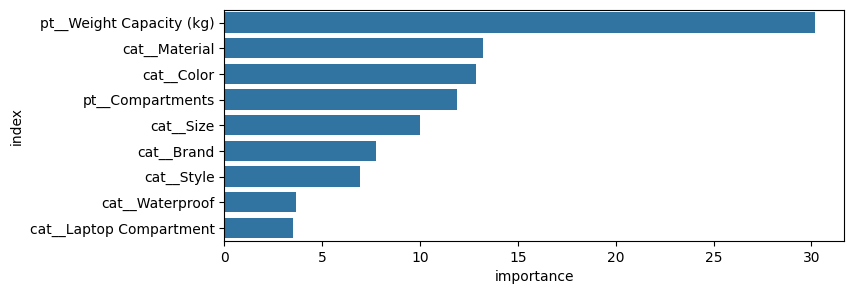

In [46]:
plt.figure(figsize=(8, 3))
sns.barplot(
    result['model_result'][0]['feature_importance'].sort_values(ascending = False).rename('importance').to_frame().reset_index(), 
    y = 'index', x = 'importance'
)
plt.show()

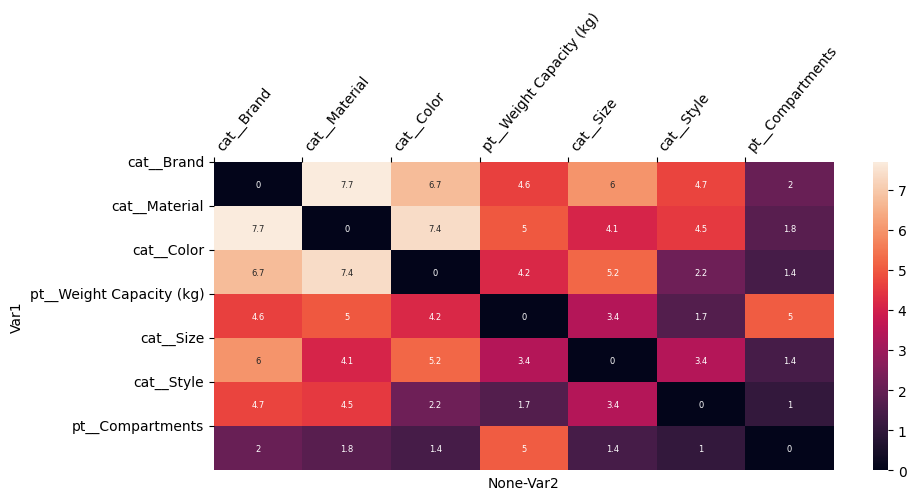

In [47]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 4))
sns.heatmap(df_cb_inter, annot=True, annot_kws = {'size': 6})
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

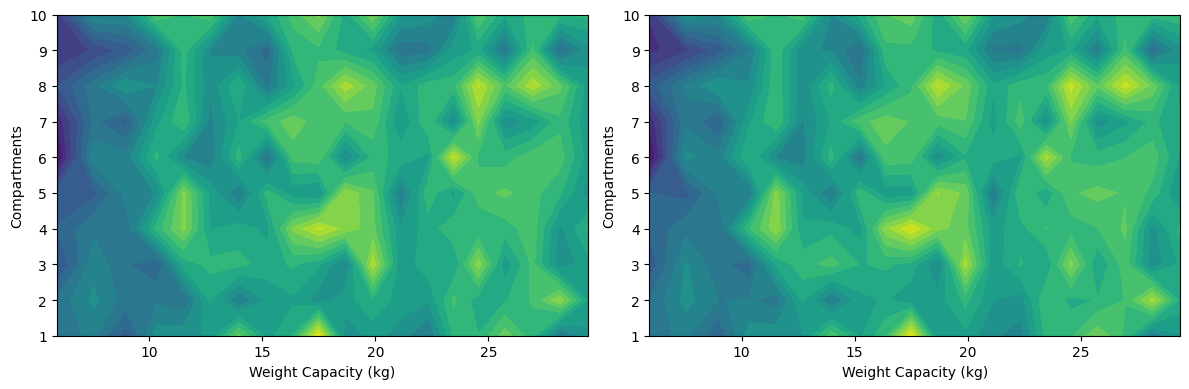

In [48]:
# We haven't investigated the interaction between Compartments and Weight Capacity. Let's visualize their interaction.
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
df_train.assign(
    wt100 = lambda x: pd.qcut(x['Weight Capacity (kg)'], q = 20, duplicates = 'drop').pipe(lambda x: x.apply(lambda x: x.left + x.right).astype(float) / 2)
).groupby(['Compartments', 'wt100'], observed=True)[target].mean().unstack().pipe(
    lambda x: axes[0].contourf(*np.meshgrid(x.columns, x.index), x.values, cmap = 'viridis', levels = 20)
)
axes[0].set_xlabel('Weight Capacity (kg)')
axes[0].set_ylabel('Compartments')

# Through a Kruskal analysis of the association between categorical variables and the Target, Material showed high association. 
# To remove the influence of these categorical variables, we plot graphs of the Target's mean and the deviation from the overall Target for each of these four variables.
df_train.assign(
    wt100 = lambda x: pd.qcut(x['Weight Capacity (kg)'], q = 20, duplicates = 'drop').pipe(lambda x: x.apply(lambda x: x.left + x.right).astype(float) / 2),
    target_diff = lambda x: x[target] - x.groupby(['Material'], observed=True)[target].transform('mean')
).groupby(['Compartments', 'wt100'], observed=True)['target_diff'].mean().unstack().pipe(
    lambda x: axes[1].contourf(*np.meshgrid(x.columns, x.index), x.values, cmap = 'viridis', levels = 20)
)
axes[1].set_xlabel('Weight Capacity (kg)')
axes[1].set_ylabel('Compartments')
plt.tight_layout()
plt.show()

When comparing the data with and without the influence of the categorical variables, similar trends are observed. The interaction between the two variables appears to be a globally valid phenomenon, and once the influence of the categorical variables is removed, the mutual association between the two variables becomes more pronounced.

It would be better to regard Compartments as categorical variable.

In [49]:
kruskal(*df_train.groupby('Compartments')[target].agg(list))

KruskalResult(statistic=33.705188565420684, pvalue=0.00010059632665359042)

In [86]:
df_train['Compartments_c'] = df_train['Compartments'].astype('category')
df_train['wt_ic'] = df_train['Weight Capacity (kg)'].fillna(df_train['Weight Capacity (kg)'].median()).round().astype('int').astype('category')

In [81]:
rmse_comb_cat_list = sc.cache_result(
    'comb_cat_rmse2',
    lambda : [
        get_comb_cat_rmse_tgt(i, kf, X_cat + ['wt_ic']) for i in range(1, len(X_cat + ['wt_ic']) + 1)
    ], rerun = 1
)
for i in rmse_comb_cat_list:
    display(i.iloc[:5])

wt_ic       38.930377
Material    38.934925
Color       38.934949
Brand       38.937442
Size        38.940097
dtype: float64

Material            Color       38.931884
Laptop Compartment  wt_ic       38.932211
Brand               Material    38.933552
Waterproof          wt_ic       38.933573
Brand               Color       38.934159
dtype: float64

Material  Waterproof          Color                 38.934496
          Laptop Compartment  Color                 38.934530
          Size                Color                 38.934694
Brand     Material            Waterproof            38.934730
                              Laptop Compartment    38.935133
dtype: float64

Material  Laptop Compartment  Waterproof          Color         38.937816
Brand     Material            Laptop Compartment  Waterproof    38.938518
Material  Laptop Compartment  Waterproof          Style         38.938879
          Size                Laptop Compartment  Waterproof    38.940079
                              Waterproof          Style         38.940772
dtype: float64

Material  Size                Laptop Compartment  Waterproof          Style         38.949328
Brand     Size                Laptop Compartment  Waterproof          Style         38.952619
          Material            Laptop Compartment  Waterproof          Style         38.954429
Size      Laptop Compartment  Waterproof          Style               Color         38.955149
Brand     Material            Size                Laptop Compartment  Waterproof    38.955180
dtype: float64

Brand     Material  Size                Laptop Compartment  Waterproof  Style    39.001839
Material  Size      Laptop Compartment  Waterproof          Style       Color    39.014767
Brand     Size      Laptop Compartment  Waterproof          Style       Color    39.034922
          Material  Size                Laptop Compartment  Waterproof  Color    39.063883
                    Laptop Compartment  Waterproof          Style       Color    39.073126
dtype: float64

Brand     Material  Size                Laptop Compartment  Waterproof  Style  Color    39.338896
                                                                               wt_ic    40.667440
Material  Size      Laptop Compartment  Waterproof          Style       Color  wt_ic    41.039518
Brand     Size      Laptop Compartment  Waterproof          Style       Color  wt_ic    41.607549
          Material  Size                Laptop Compartment  Waterproof  Color  wt_ic    42.563346
dtype: float64

Brand  Material  Size  Laptop Compartment  Waterproof  Style  Color  wt_ic    46.979602
dtype: float64

In [85]:
rmse_tgt_enc_cat(['wt_ic', 'Compartments_c'], cv = kf)

38.95183711773026

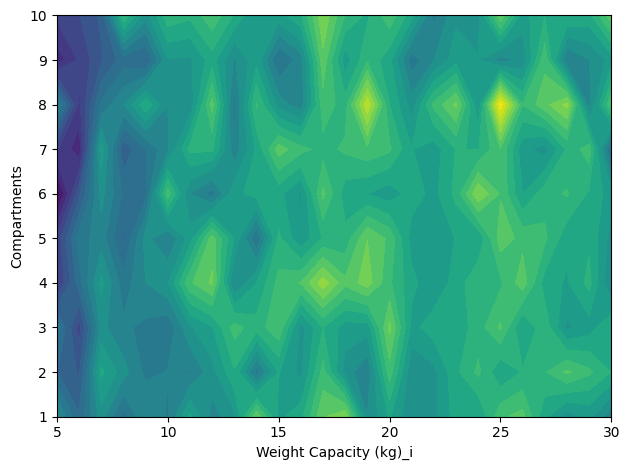

In [75]:
df_train.assign(
    wt_i = lambda x: x['Weight Capacity (kg)'].round(),
    target_diff = lambda x: x[target] - x.groupby(['Material'], observed=True)[target].transform('mean')
).groupby(['Compartments', 'wt_i'], observed=True)['target_diff'].mean().unstack().pipe(
    lambda x: plt.contourf(*np.meshgrid(x.columns, x.index), x.values, cmap = 'viridis', levels = 20)
)
plt.xlabel('Weight Capacity (kg)_i')
plt.ylabel('Compartments')
plt.tight_layout()
plt.show()

# Imputation of missing values

## Simple Impute: mode

In [167]:
from sklearn.impute import SimpleImputer
X_imp = df_train.isna().sum().pipe(lambda x: x.loc[x > 0]).index.tolist()
X_imp

['Brand',
 'Material',
 'Size',
 'Laptop Compartment',
 'Waterproof',
 'Style',
 'Color',
 'Weight Capacity (kg)']

In [184]:
df_imp = sgpp.ApplyWrapper(
    SimpleImputer(strategy = 'most_frequent').set_output(transform='pandas'),
    X_imp[:-1]
).fit_transform(df_train)

In [185]:
hparams = {
    'model_params' : {'n_estimators': 300, 'learning_rate': 0.05},
    'X_num': X_num, 'X_cat': X_cat,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_simple_impute_2',
    lambda : sgml.cv(df_imp, kf, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance], task_type = 'GPU'),
    rerun = 1
)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

39.01000221887509

## Simple Impute: to Unknown

In [178]:
df_imp = sgpp.ApplyWrapper(
    sgpp.CatArrangerFreq(1, na_value = 'Unknown'),
    X_imp[:-1]
).fit_transform(df_train)

In [182]:
hparams = {
    'model_params' : {'n_estimators': 300, 'learning_rate': 0.05},
    'X_num': X_num, 'X_cat': X_cat,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_simple_impute',
    lambda : sgml.cv(df_imp, kf, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance], task_type = 'GPU'),
    rerun = 0
)
np.mean(result['valid_scores'])

38.9967502911919

## LGB Iterative Impute

In [229]:
importlib.reload(sgpp)

<module 'sgpp' from '/home/sun9sun9/jnote/sunkusun9/kaggle/PGS5/PGS5_ep2/sgpp.py'>

In [230]:
lgb_iter_imp = sgpp.ApplyWrapper(
    sgpp.LGBMIterativeImputer(
        hparams = {'n_estimators': 300, 'learning_rate': 0.05}, X_num = X_num, X_cat = X_cat, 
        targets = X_imp,
        n_iter = 2, validation_fraction = 0.1
    ), vals = X_num + X_cat
)

In [232]:
lgb_iter_imp = sc.cache_result(
    'lgb_imputer',
    lambda : lgb_iter_imp.fit(pd.concat([
        df_train[X_num + X_cat],
        df_test[X_num + X_cat]
    ])), rerun = 1
)
df_imp = lgb_iter_imp.transform(df_train)

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Step:   0%|          | 0/8 [00:00<?, ?it/s]

In [234]:
hparams = {
    'model_params' : {'n_estimators': 300, 'learning_rate': 0.05},
    'X_num': X_num, 'X_cat': X_cat,
    #'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_lgb_iter_impute',
    lambda : sgml.cv(df_imp, kf, hparams, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance], task_type = 'GPU'),
    rerun = 0
)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

39.015066665637015

# Including original dataset